In [55]:
from typing import Callable

import polars as pl
import matplotlib.pyplot as plt
import blitzbeaver as bb
import json

In [3]:
csv_path = "../../aptihramy/data/csv_cleaned"
beaver_folder_path = "../data/beaver_files"
json_folder_path = "../data/json_files"

In [54]:
class MetricsResult:
    def __init__(
        self,
        verifier: dict[str, float],
        memory_distance: dict[str, float],
        start_years: list[int],
        end_years: list[int],
        chain_lengths: list[int],
        avg_records_match: float,
        avg_trackers_match: float,
        histogram_records: list[int],
        histogram_trackers: list[int],
    ) -> None:
        self.verifier = verifier
        self.memory_distance = memory_distance
        self.start_years = start_years
        self.end_years = end_years
        self.chain_lengths = chain_lengths
        self.avg_records_match = avg_records_match
        self.avg_trackers_match = avg_trackers_match
        self.histogram_records = histogram_records
        self.histogram_trackers = histogram_trackers


class StatClass:
    def __init__(
        self,
        name: str,
        x: list[float],
        y: list[float],
        configs: list[bb.TrackingConfig],
    ) -> None:
        self.name = name
        self.x = x
        self.y = y
        self.configs = configs

In [5]:
def load_metrics_results(filename: str) -> list[tuple[bb.TrackingConfig, MetricsResult]]:
    filepath = f"{json_folder_path}/{filename}"
    with open(filepath, "r") as file:
        data = json.load(file)
    results = []
    for raw in data:
        config = bb.deserialize_tracking_config(raw["config"])
        data = raw["data"]
        metrics_result = MetricsResult(
            verifier=data["verifier"],
            memory_distance=data["memory_distance"],
            start_years=data["start_years"],
            end_years=data["end_years"],
            chain_lengths=data["chain_lengths"],
            avg_records_match=data["avg_records_match"],
            avg_trackers_match=data["avg_trackers_match"],
            histogram_records=data["histogram_records"],
            histogram_trackers=data["histogram_trackers"],
        )
        results.append((config, metrics_result))
    
    return results

In [17]:
def histogram_mean(histogram: list[int]) -> float:
    total = 0
    for i, count in enumerate(histogram):
        total += i * count
    return total / sum(histogram)

def histogram_median(histogram: list[int]) -> float:
    n = sum(histogram)
    half = n // 2
    i = 0
    while n > half:
        n -= histogram[i]
        i += 1
    return i - 1

In [49]:
results = load_metrics_results("chunk_0_49.json")
results += load_metrics_results("chunk_50_99.json")

In [41]:
r = results[3]

In [96]:
def compute_stat_classes(
    results: list[tuple[bb.TrackingConfig, MetricsResult]],
    groupby: Callable[[bb.TrackingConfig], str],
    max_x: int | None = None,
) -> list[StatClass]:

    groups: dict[str, StatClass] = {}

    for result in results:
        config = result[0]
        metrics = result[1]
        x = histogram_mean(metrics.histogram_records)
        y = histogram_mean(metrics.chain_lengths)

        if max_x is not None and x >= max_x:
            continue

        name = groupby(config)

        if not name in groups:
            groups[name] = StatClass(name, [], [], [])
        group = groups[name]

        group.x.append(x)
        group.y.append(y)
        group.configs.append(config)

    return list(groups.values())

def display_stat_classes(stat_classes: list[StatClass]) -> None:
    plt.figure(figsize=(14, 10))
    for stat_class in stat_classes:
        plt.scatter(stat_class.x, stat_class.y, label=stat_class.name)
    plt.legend()
    plt.plot()

In [99]:
classes = compute_stat_classes(
    results,
    lambda c: str(c.tracker.memories[0].memory_strategy),
    max_x=100,
)

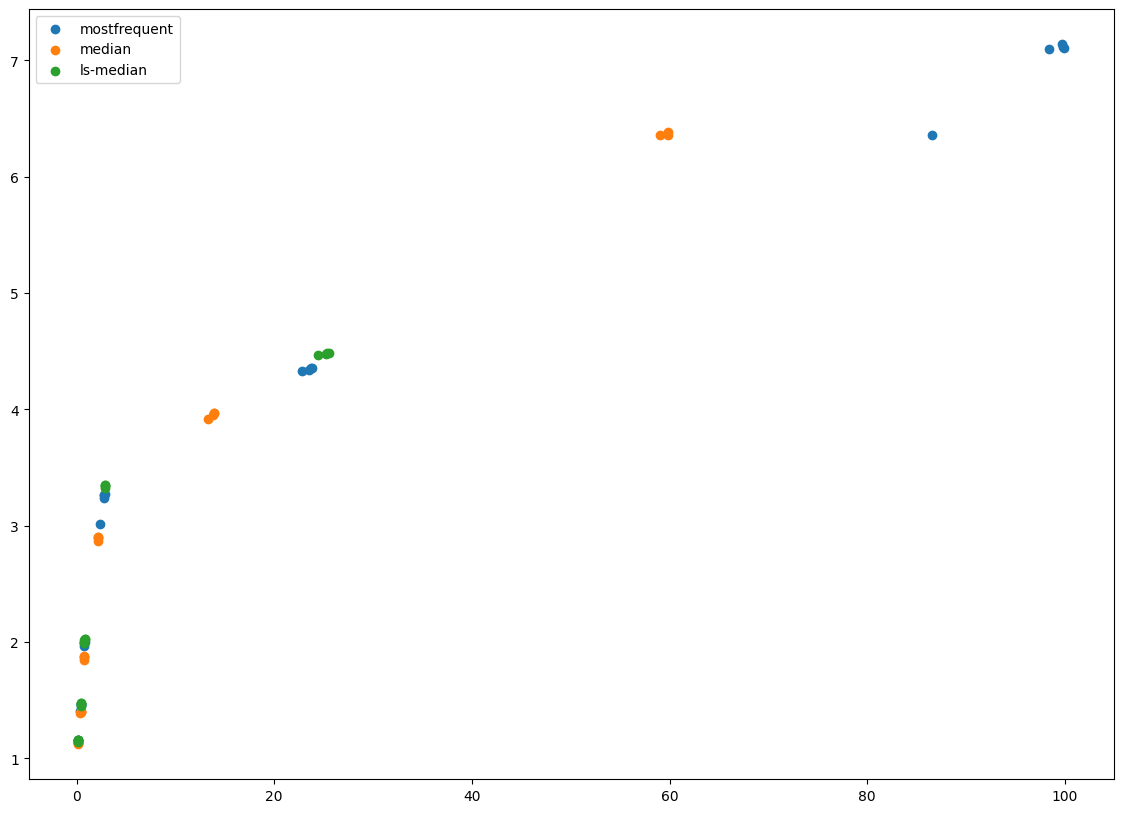

In [100]:
display_stat_classes(classes)